In [2]:
import numpy as np
import cvxpy as cp
from scipy.integrate import odeint
from scipy import interpolate
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from numpy import sin
from numpy import cos
from numpy import tan
from numpy import pi

In [68]:
## Vehicle Parameters
l = 0.05
xr = 0.01
yr = 0
v_ub = 1
v_lb = 0
phi_ub = pi/3
phi_lb = -pi/3

Rmin = l/np.arctan(phi_ub)
track_width = 0.5

# Trajectory Smoothing

In [5]:
# Support Functions
def prog_param(x,y):
  n = len(x)
  prog = np.zeros(n)
  for i in range(0,n-1):
    prog[i+1] = np.linalg.norm(np.array([x[i]-x[i+1],y[i]-y[i+1]])) + prog[i]
  return prog


def track_generator(xy_coords):
  step = 0.01
  P = np.array([[0],[0]])
  for i in range(0,len(xy_coords)-1):
    xy_start = xy_coords[i]
    xy_end = xy_coords[i+1]
    x_start = xy_start[0]
    y_start = xy_start[1]
    x_end = xy_end[0]
    y_end = xy_end[1]
    x_step = int(np.ceil(np.abs(x_end-x_start)/step) + 1)
    y_step = int(np.ceil(np.abs(y_end-y_start)/step) + 1)
    if x_step <= y_step:
      x_step = y_step
    else:
      y_step = x_step
    x = np.linspace(x_start,x_end,x_step)
    y = np.linspace(y_start,y_end,y_step)
    P = np.hstack((P,np.vstack((x,y))))

  return P[:,1:].T

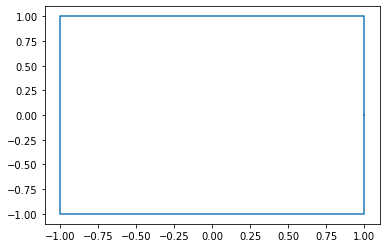

In [156]:
#### Track Contour Generate ####
## Track1: Square
points = np.array([[1,0],
                   [1,1],
                   [-1,1],
                   [-1,-1],
                   [1,-1],
                   [1,0]])

## Track2: Double square
# points = np.array([[0,0],
#                    [1,0],
#                    [1,1],
#                    [0,1],
#                    [0,-1],
#                    [-1,-1],
#                    [-1,0],
#                    [0,0]])

## Track3: Star
# points = np.array([[1,-1],
#                    [0,1],
#                    [-1,-1],
#                    [1.5,0],
#                    [-1.5,0],
#                    [1,-1]])

P = track_generator(points)
plt.plot(P[:,0],P[:,1])

In [ ]:
#### Smoothing Trajectory ####
r = track_width/2
d = np.linalg.norm(P[0]-P[1])
P_num = P.shape[0]

Q = cp.Variable((P_num,2))

cost = 0
constr = []

constr += [Q[0] == P[0] , Q[P_num-1] == P[P_num-1] , Q[1] == P[1] , Q[P_num-2] == P[P_num-2]]
for i in range(1+1,P_num-1-1):  
  cost += cp.quad_form(Q[i-1]-2*Q[i]+Q[i+1], np.eye(2)) #+ 1000*cp.norm(slack_track[i-1], 1)  
  constr += [cp.norm(Q[i]-P[i],2) <= r]
  constr += [cp.norm(Q[i-1]-2*Q[i]+Q[i+1],2) <= d**2/Rmin ]#+ slack_track[i-1]]


prob1 = cp.Problem(cp.Minimize(cost), constr)
prob1.solve(solver=cp.ECOS)

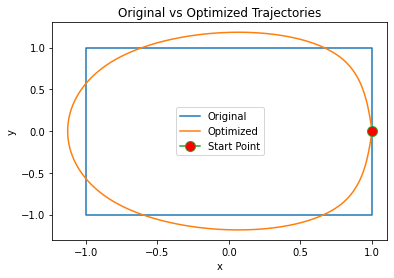

In [158]:
#### Ploting Trajectories ####
plt.plot(P[:,0],P[:,1])
plt.plot(Q[:,0].value,Q[:,1].value)
plt.plot(Q[0,0].value,Q[0,1].value, marker="o", markersize=10, markerfacecolor="red")
plt.title("Original vs Optimized Trajectories")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(["Original","Optimized","Start Point"])
plt.show()

In [159]:
#### Cubic Spline Fitting ####
x = Q[:,0].value
y = Q[:,1].value
prog = prog_param(x,y)
prog = prog/prog[-1]   # Normalized progress
x_s = CubicSpline(prog, x)
y_s = CubicSpline(prog, y) 

theta = np.arctan2(y_s(prog,1),x_s(prog,1))
theta_s = CubicSpline(prog, theta) 

# Speed Optimization

In [160]:
#### Support Functions ####
def h(s):
  h = np.array([x_s(s),y_s(s)]) #,theta_s(s)
  return h

def dh_ds(s):
  dh_ds = np.array([x_s(s,1),y_s(s,1)]) #,theta_s(s,1)
  return dh_ds

def d2h_ds2(s):
  d2h_ds2 = np.array([x_s(s,2),y_s(s,2)]) # 
  return d2h_ds2

def r_s(s,ub):
  s_bar_down = 0.2
  s_bar_up = 0.8
  r = 0
  if s>=0 and s<=s_bar_down:
    r = (ub/s_bar_down)*s
  elif s>=s_bar_down and s<=s_bar_up:
    r = ub
  else:
    r = ub-ub*(s-s_bar_up)/(1-s_bar_up)

  return r

In [ ]:
#### Optimizing Speed ####
## Initialization
N = 150
lamda = 0.3
delta_s = (1-0)/N
epsilon = 0.001
s = np.linspace(0,1,N+1) # Discretization wrt s

## Problem Formulation
a = cp.Variable(N+1)
b = cp.Variable(N+1)
c = cp.Variable(N+1)
d = cp.Variable(N+1)

slack = cp.Variable((3,N+1))

u = cp.Variable((2,N+1))  # u = [vx , vy]

cost = 0
constr = []

cost += 0.5*((1-lamda)*d[0]+(1+lamda)*d[1])*(1-lamda)*delta_s + 0.5*((1+lamda)*d[N-1]+(1-lamda)*d[N])*(1-lamda)*delta_s
for i in range(1,N-1):
  cost += 0.5*(d[i]+d[i+1])*delta_s

constr += [b[0] == 0 , b[N] == 0]
constr += [c[0] == 0 , c[N] == 0]
for k in range(0,N+1):
  constr += [dh_ds(s[k])*c[k] == u[:,k],\
            cp.norm(u[:,k],2) <= r_s(s[k],v_ub)]   # Dynamics
  constr += [cp.SOC(b[k] + 1, np.array([[0,2],[1,0]]) @ cp.hstack((b[k],c[k])) + np.array([0,-1]))]

for j in range(0,N):
  constr += [b[j+1]-b[j] == delta_s*(a[j+1]+a[j])]

for k in range(1,N):
  constr += [b[k] >= epsilon , c[k] >= epsilon]
  constr += [cp.SOC(c[k] + d[k], np.array([[0,0],[1,-1]]) @ cp.hstack((c[k],d[k])) + np.array([2,0]))]

constr += [cp.SOC((1-lamda)*c[0]+lamda*c[1]+(1-lamda)*d[0]+lamda*d[1], np.array([[0,0,0,0],[(1-lamda),lamda,-(1-lamda),-lamda]]) @ cp.hstack((c[0],c[1],d[0],d[1])) + np.array([2,0]))]
constr += [cp.SOC(lamda*c[N-1]+(1-lamda)*c[N]+lamda*d[N-1]+(1-lamda)*d[N], np.array([[0,0,0,0],[lamda,(1-lamda),-lamda,-(1-lamda)]]) @ cp.hstack((c[N-1],c[N],d[N-1],d[N])) + np.array([2,0]))]

prob2 = cp.Problem(cp.Minimize(cost), constr)
prob2.solve(solver=cp.ECOS)

Text(0, 0.5, 'vy')

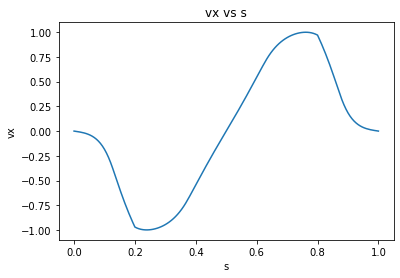

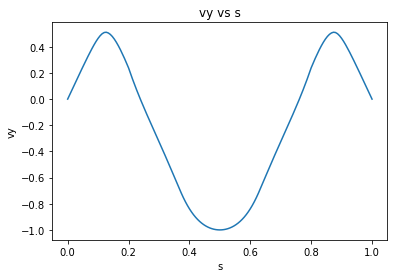

In [162]:
#### Optimized Controls ####
plt.figure(1)
plt.plot(s,u.value[0,:])
plt.title("vx vs s")
plt.xlabel('s')
plt.ylabel('vx')

plt.figure(2)
plt.plot(s,u.value[1,:])
plt.title("vy vs s")
plt.xlabel('s')
plt.ylabel('vy')

In [163]:
#### Recover time t from s ####
t  = np.zeros(N+1)
t[0] = 0
for k in range(1,N+1):
  t[k] = t[k-1]+0.5*(d[k-1].value+d[k].value)*(s[k]-s[k-1])

In [164]:
#### Interpolate Reference Functions ###
p = np.zeros((2,N+1))
for i in range(0,N+1):
  p[:,i] = h(s[i])

px_t = interpolate.interp1d(t, p[0,:])
py_t = interpolate.interp1d(t, p[1,:])

pxdot_t = interpolate.interp1d(t, u.value[0,:])
pydot_t = interpolate.interp1d(t, u.value[1,:])


# Demo

In [165]:
#### Support Functions ####
def P_xy(x,y,theta):
  P = np.array([x,y]) + np.array([[cos(theta),-sin(theta)],[sin(theta),cos(theta)]])@np.array([xr,yr])
  return P

def f_kinematics(v_in,phi_in,theta_in):
  f = np.array([v_in*cos(theta_in),v*sin(theta_in),v*tan(phi_in)/l])
  return f

def v_phi_optimal(Px_dot, Py_dot, theta):
  v_w = cp.Variable(2)

  A = np.array([[cos(theta),-xr*sin(theta)-yr*cos(theta)],[sin(theta),xr*cos(theta)-yr*sin(theta)]])
  b = np.array([Px_dot, Py_dot])
  cost = cp.sum_squares(A @ v_w - b)
  constr = [v_w[0] <= v_ub, v_w[0] >= v_lb,
            v_w[1] <= (tan(phi_ub)/l)*v_w[0], v_w[1] >= (tan(phi_lb)/l)*v_w[0]]
  
  prob3 = cp.Problem(cp.Minimize(cost), constr)
  prob3.solve()
  # print(prob3.value)
  v = v_w.value[0]
  w = v_w.value[1]

  if v <= 1e-3:
    phi = 0
  else:
    phi = np.arctan2(w*l,v)
    # phi = max(min(phi_ub, phi), phi_lb)

  return v, phi


In [166]:
#### Mobile Robot Simulation ####
## Initialize Position and Orientation
x0 = 1.1
y0 = 0.1
theta0 = pi/2
q_sim = np.array([[x0,y0,theta0]])

## PID Feedback Gains
Kx = 2
Ky = 2

## Simulating Mobile Robot
Ts = 0.01
Nsim = int(t[-1]/Ts)
v_sim = []
phi_sim = []
t_sim = []
for i in range(0,Nsim):
  tsim = i*Ts
  t_sim.append(tsim)
  q_current = q_sim[-1,:]
  p_current = P_xy(q_current[0],q_current[1],q_current[2])
  p_ref = np.array([px_t(tsim),py_t(tsim)])

  p_error = p_ref - p_current
  pdot_ref = np.array([pxdot_t(tsim),pydot_t(tsim)])
  pdot = pdot_ref + np.array([[Kx,0],[0,Ky]])@p_error
  v, phi = v_phi_optimal(pdot[0], pdot[1], q_current[2])
  v_sim.append(v)
  phi_sim.append(phi)

  q_next = q_current + Ts*f_kinematics(v,phi,q_current[2])
  q_sim = np.vstack((q_sim,q_next))

Text(0, 0.5, 'Steering (rad)')

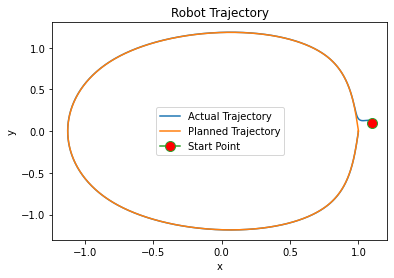

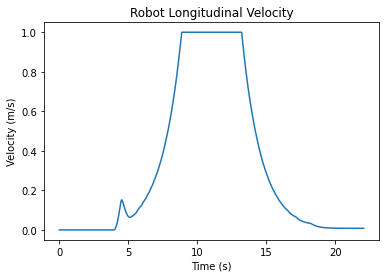

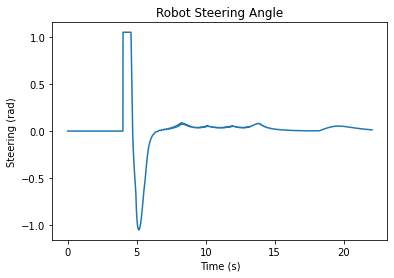

In [167]:
#### Plotting Simulation Results ####
plt.figure(1)
plt.plot(q_sim[:,0],q_sim[:,1])
plt.plot(Q[:,0].value,Q[:,1].value)
plt.plot(q_sim[0,0],q_sim[0,1], marker="o", markersize=10, markerfacecolor="red")
plt.title("Robot Trajectory")
plt.xlabel('x')
plt.ylabel('y')
plt.legend(["Actual Trajectory","Planned Trajectory","Start Point"])

plt.figure(2)
plt.plot(t_sim,v_sim)
plt.title("Robot Longitudinal Velocity")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")

plt.figure(3)
plt.plot(t_sim,phi_sim)
plt.title("Robot Steering Angle")
plt.xlabel("Time (s)")
plt.ylabel("Steering (rad)")
